# CS178 Final Project
## IMDB Reviews dataset
### Students:
Rebecca Park : \
Nick Hosun Song : 65482420

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, vstack
from sklearn.svm import SVC , LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , make_scorer
from scipy.sparse import csr_matrix
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
## conda install libsvm
## conda install libsvm-python
from libsvm.svmutil import svm_train, svm_predict, svm_problem, svm_parameter , svm_read_problem
import random




In [2]:
#Load the vocab from given data will correlate to bagofwords(feat) file
def load_vocab(vocab_file):
    with open(vocab_file, 'r',encoding ='utf-8') as file:
        vocab = file.read().splitlines()
    return {index: word for index, word in enumerate(vocab)}

vocab = load_vocab('imdb.vocab')
def convert_to_csr(data, num_features):
    row_ind = []
    col_ind = []
    data_values = []

    for i, row in enumerate(data):
        for feature_index, feature_value in row.items():
            row_ind.append(i)
            col_ind.append(feature_index)
            data_values.append(feature_value)

    return csr_matrix((data_values, (row_ind, col_ind)), shape=(len(data), num_features))

num_features = len(vocab)

y_train, X_train = svm_read_problem('train/labeledBow.feat')
y_test, X_test = svm_read_problem('test/labeledBow.feat')

X_train_csr = convert_to_csr(X_train,num_features)
X_test_csr = convert_to_csr(X_test,num_features)

#convert labels into binary format
#positive = 1 (7 , 8 , 9 , 10)
#negative = 0 (1, 2 , 3 , 4)
y_train_binary = [1 if y > 6 else 0 for y in y_train]
y_test_binary = [1 if y > 6 else 0 for y in y_test]



## Sentiment Analysis
We are focusing on creating a sentiment analysis which is a natural language processing task that tries to determine 
the emotional tone of a piece of text which in our case is an IMDB movie review. We will be classifying our data into 
positive (1) and negative (0) labels. Our data was provided to us in a .feat format so all we had to do for data preprocessing
was convert the format into csr in order for us to be able to use Scikit_learn packages.

## Linear SVM
Our first type of model we chose was an SVM with a linear kernel. The linear kernel tends to work well when data is linearly separable in a feature space.
The hyperparameter that we chose to tune was the regularization strength parameter (C). We chose to use L2 regularization as it doesn't force feature selection as aggressively as L1 regularization. Tuning the reglarization is done in order to prevent overfitting and improve the generalization of the model. The strength parameter C encourages the model to have smaller weights/coefficients for each of the features, which will make the model less sensitive to the noise in the training data. This will help us control the margin between the decision boundary and the training points. In using a Linear SVM we are aiming to find the decision boundary that maximizes the margin between the classes while also correctly classifying the training examples. 

C = 1e-05
Cross-Validation Error Rate: 0.2402
Cross-Validation F1 Score: 0.7581
Test Error Rate: 0.2205
Test F1 Score: 0.7795

C = 0.0001
Cross-Validation Error Rate: 0.1650
Cross-Validation F1 Score: 0.8368
Test Error Rate: 0.1490
Test F1 Score: 0.8526

C = 0.001
Cross-Validation Error Rate: 0.1362
Cross-Validation F1 Score: 0.8640
Test Error Rate: 0.1174
Test F1 Score: 0.8831

C = 0.01
Cross-Validation Error Rate: 0.1429
Cross-Validation F1 Score: 0.8555
Test Error Rate: 0.1222
Test F1 Score: 0.8774

C = 0.1
Cross-Validation Error Rate: 0.1666
Cross-Validation F1 Score: 0.8304
Test Error Rate: 0.1414
Test F1 Score: 0.8570

C = 1
Cross-Validation Error Rate: 0.1750
Cross-Validation F1 Score: 0.8215
Test Error Rate: 0.1513
Test F1 Score: 0.8468



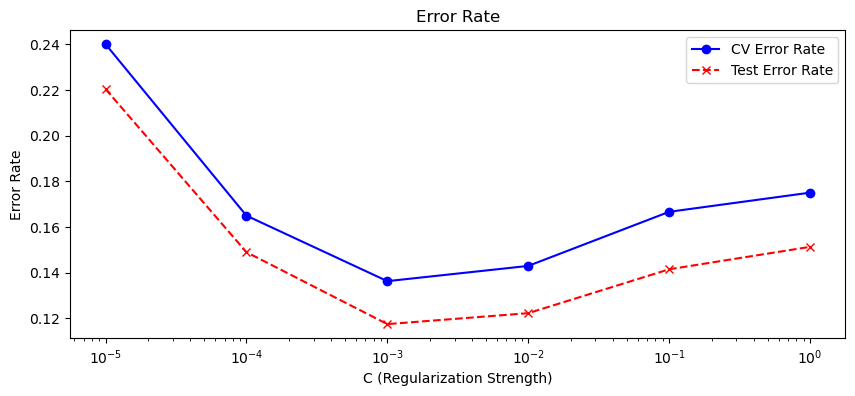

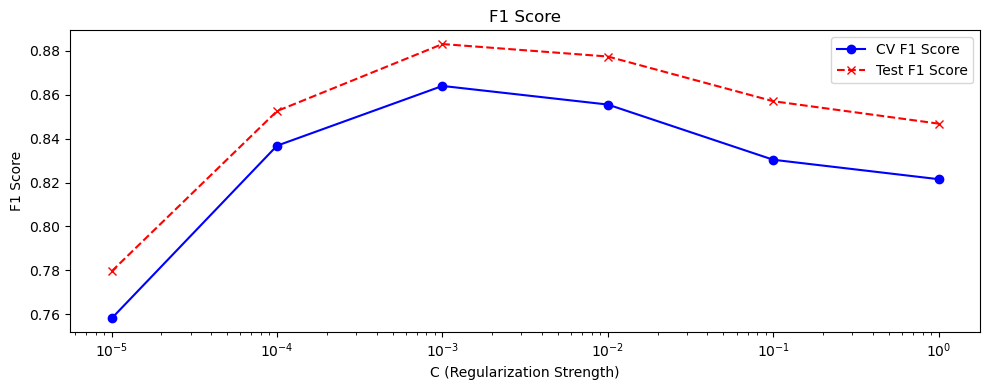

In [3]:
# Testing with linear kernel with different regularization strengths and cross-validation to test different metrics
C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

# Scoring metrics definitions for only error rate and F1 score
scoring_metrics = {
    'error_rate': make_scorer(lambda y, y_pred, **kwargs: 1 - accuracy_score(y, y_pred)),
    'f1': make_scorer(f1_score)
}

# Dictionaries to store cross-validation and test metrics (error_rate, f1)
cv_metrics = {'error_rate': [], 'f1': []}
test_metrics = {'error_rate': [], 'f1': []}

# Loop through and create a model for each regularization strength
for C in C_values:
    model = LinearSVC(C=C, dual=False, max_iter=5000)

    # For each regularization strength, perform 3-fold cross-validation and score the average of each metric
    cv_results = cross_validate(model, X_train_csr, y_train_binary, cv=3, scoring=scoring_metrics,n_jobs=-1)
    cv_metrics['error_rate'].append(np.mean(cv_results['test_error_rate']))
    cv_metrics['f1'].append(np.mean(cv_results['test_f1']))

    # Do a final testing with a simple train / test split
    model.fit(X_train_csr, y_train_binary)
    y_pred = model.predict(X_test_csr)
    test_metrics['error_rate'].append(1 - accuracy_score(y_test_binary, y_pred))
    test_metrics['f1'].append(f1_score(y_test_binary, y_pred))

    # Print the results for each C value
    print(f"C = {C}")
    print(f"Cross-Validation Error Rate: {cv_metrics['error_rate'][-1]:.4f}")
    print(f"Cross-Validation F1 Score: {cv_metrics['f1'][-1]:.4f}")
    print(f"Test Error Rate: {test_metrics['error_rate'][-1]:.4f}")
    print(f"Test F1 Score: {test_metrics['f1'][-1]:.4f}")
    print()

import matplotlib.pyplot as plt

def plot_metric(metric, title):
    plt.plot(C_values, cv_metrics[metric], marker='o', color='b', label='CV ' + title)
    plt.plot(C_values, test_metrics[metric], linestyle='--', marker='x', color='r', label='Test ' + title)
    plt.xscale('log')
    plt.xlabel('C (Regularization Strength)')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()

# Plot the metrics for error rate and F1 score
plt.figure(figsize=(10, 4))
plot_metric('error_rate', 'Error Rate')

plt.figure(figsize=(10, 4))
plot_metric('f1', 'F1 Score')

plt.tight_layout()
plt.show()


## Analysis of Linear SVM tuning
In our analysis of the Linear SVM, after computing all of the linear models using the different Regularization strengths, we measure 4 different metrics.
- Error Rate : the proportion of misclassified instances
- Precision : proportion of models ability to correctly predict positive cases (minimize false positives)
- Recall : proportion of true positive predictions out of all the actual positive cases (minimize false negatives)
- F1 score: the mean between precision and recall finds the best model that captures the balance between minimizing both false positives and negatives.

From the graphs shown above, we can clearly tell that when using a Linear SVM a regularization strength of .001 gives us the best overall performance. If we were to focus only on the precision metric we cold arge that choosing to go with .01 would be better, but for our dataset we want a good balance of both false positives and negatives. So if we choose based off the error rate as well as the F1 score we can confidently say that choosing the Linear SVM model with a regularization strength of .001 is the best choice.
